In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import importlib
import yaml, itertools
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import my_utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import pandas as pd

#lib_path = "main_id_identification"
#main_path = '/'.join(lib_path.split('.')[:-1])
#saved_main = importlib.import_module(lib_path)

import main_id_identification as saved_main

with open("hparams.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

seed = hparams['seed']
my_utils.set_seed(seed)

bz = 1

net = saved_main.Current_Network(hparams, 1251)
net.load_state_dict(torch.load('best_model.pt')['model_state_dict'])
net = net.cuda()

# IEMOCAP

In [4]:
import importlib
import yaml, itertools
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import my_utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

seed = hparams['seed']
my_utils.set_seed(seed)

bz = 1

import os 
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
"""
net = saved_main.Current_Network(hparams, 1251)
net.load_state_dict(torch.load(main_path+'/best_model.pt')['model_state_dict'])
net = net.cuda()
net.eval()"""

"\nnet = saved_main.Current_Network(hparams, 1251)\nnet.load_state_dict(torch.load(main_path+'/best_model.pt')['model_state_dict'])\nnet = net.cuda()\nnet.eval()"

In [5]:
import torchaudio
from torch.utils.data import Dataset
import random
import pandas as pd

class WavDataset(Dataset):
    def __init__(self, apply_vad):
        
        self.csv = pd.read_csv('/media/ubuntu/SSD2/Dataset/IEMOCAP_full_release/emo_vad_sec.csv')
        self.csv = self.csv.replace('exc', 'hapexc')
        self.csv = self.csv.replace('hap', 'hapexc')

        mask = [True if e in ['ang', 'hapexc', 'sad', 'neu'] else False for e in self.csv['emotion']]
        self.csv = self.csv[mask]
        self.csv = self.csv.reset_index(drop=True)
        
        self.sr = 16000
        self.max_sec = 15.0

        self.apply_vad = apply_vad

        self.aranged_id_num = list(range(1,11))
    
    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):

        data = self.csv.iloc[idx]
        ids = data['session']
        pid = self.aranged_id_num.index(data['id_num'])

        emo = data['emotion']

        if not self.apply_vad:
            wav_path = '/media/ubuntu/SSD2/Dataset/IEMOCAP_full_release/Session'+str(data['fold'])\
                +'/sentences/wav/' + '_'.join(ids.split('_')[:-1]) + '/' + ids +'.wav'
        else:
            wav_path = '/media/ubuntu/SSD2/Dataset/IEMOCAP_VAD/Session'+str(data['fold'])\
                +'/' + '_'.join(ids.split('_')[:-1]) + '/' + ids +'.wav'
        
        wav, sr = torchaudio.load(wav_path, normalize=True)
        length = wav.shape[-1] / self.sr
            
        if (length > self.max_sec):
            max_len = int(self.sr * self.max_sec)
            offset = random.randint(0, wav.shape[1] - max_len - 1)
            wav = wav[:, offset:offset+max_len]

        inputs = wav.transpose(0, 1).squeeze(1)
        
        return inputs, pid, emo

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [7]:
def make_color_list(emo_list):
    color = {'neu':'slategrey', 'ang':'crimson', 'hap':'gold', 
             'sad':'darkblue',  'dis':'plum', 
             'sur':'steelblue', 'fea':'olivedrab'}
    
    color_list = []
    for e in emo_list:
        c = color[e[:3]]
        color_list.append(c)
        
    return color_list

def make_center_color(color_list):
    color = {'slategrey':'black', 'crimson':'orangered', 'gold':'yellow', 
             'darkblue':'blue',  'plum':'purple', 
             'steelblue':'dodgerblue', 'olivedrab':'darkolivegreen'}
    
    center_list = []
    for e in color_list:
        c = color[e]
        center_list.append(c)
        
    return center_list

In [8]:
iemo_dataset = WavDataset(apply_vad=False)
iemo_dataloader = DataLoader(iemo_dataset, batch_size=1, shuffle=False)

iemo_full_inp = []
iemo_id_list = []
iemo_sec_list = []
iemo_emo_list = []

net.eval()
for wav, name, emo in tqdm(iemo_dataloader):
    wav = wav.cuda()
    sec = wav.shape[-1] / 16000

    with torch.no_grad():
        ref_feat = net.get_feat(wav).detach().cpu()
    iemo_full_inp.append(ref_feat)
    iemo_id_list.extend(name)
    iemo_emo_list.extend(emo)
    iemo_sec_list.append(sec)

iemo_full_inp = np.array(torch.concat(iemo_full_inp, dim=0))
iemo_id_list = np.array(iemo_id_list)
iemo_emo_list = np.array(iemo_emo_list)
iemo_sec_list = np.array(iemo_sec_list)

100%|██████████| 5531/5531 [01:10<00:00, 78.76it/s] 


/home/ubuntu/anaconda3/envs/speechbrain/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


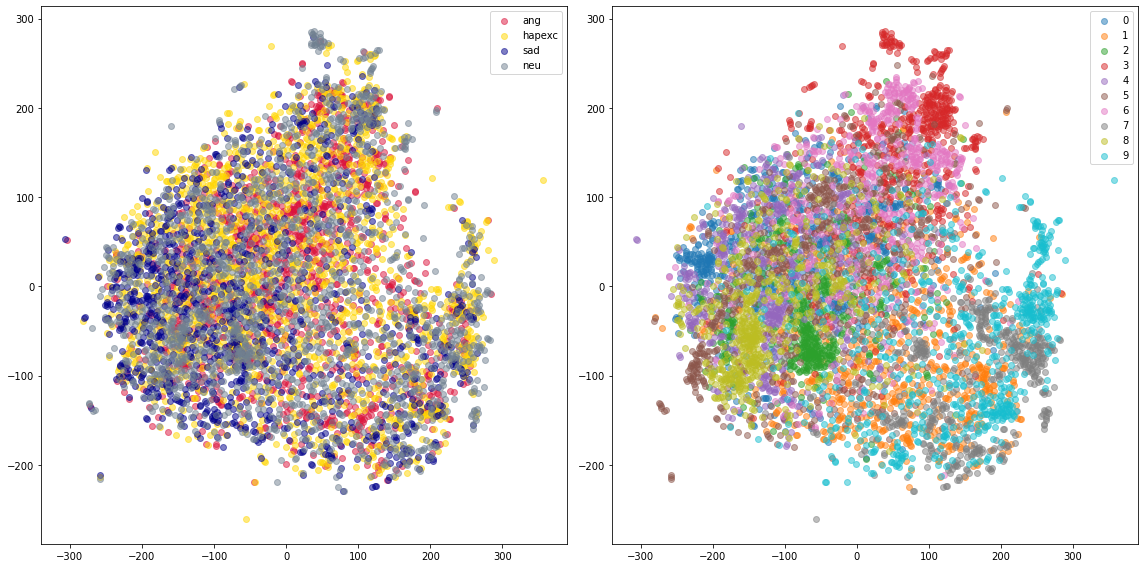

In [9]:
emo_list = ['ang', 'hapexc', 'sad', 'neu']
color_list = make_color_list(emo_list)

tsne = TSNE(n_components=2, perplexity=20, init='pca', learning_rate='auto')
y_tsne = tsne.fit_transform(iemo_full_inp)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
i = 0
for k in emo_list:
    mask = np.where(iemo_emo_list==k, True, False)

    x = y_tsne[mask][:, 0]
    y = y_tsne[mask][:, 1]
    ax[0].scatter(x, y, label=emo_list[i], color=color_list[i], alpha=0.5)
    i+=1

ax[0].legend()

i = 0
cmap1 = plt.cm.get_cmap('tab10', 10)
for k in list(set(iemo_id_list)):
    mask = np.where(iemo_id_list==k, True, False)

    x = y_tsne[mask][:, 0]
    y = y_tsne[mask][:, 1]
    ax[1].scatter(x, y, label=k, color=cmap1(i), alpha=0.5)
    i+=1
    
ax[1].legend()

plt.tight_layout()
plt.show()

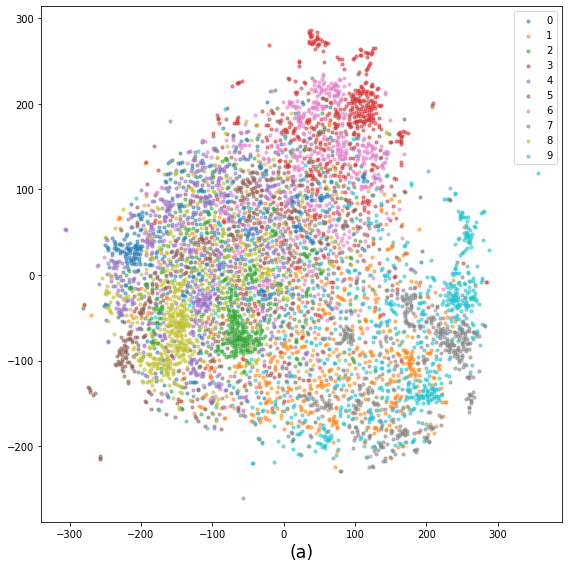

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
i = 0
cmap1 = plt.cm.get_cmap('tab10', 10)
for k in list(set(iemo_id_list)):
    mask = np.where(iemo_id_list==k, True, False)

    x = y_tsne[mask][:, 0]
    y = y_tsne[mask][:, 1]
    ax.scatter(x, y, label=k, color=cmap1(i), alpha=0.5, s=10)
    i+=1
    
ax.legend()
ax.set_xlabel('(a)', fontsize='xx-large')

plt.tight_layout()
plt.show()

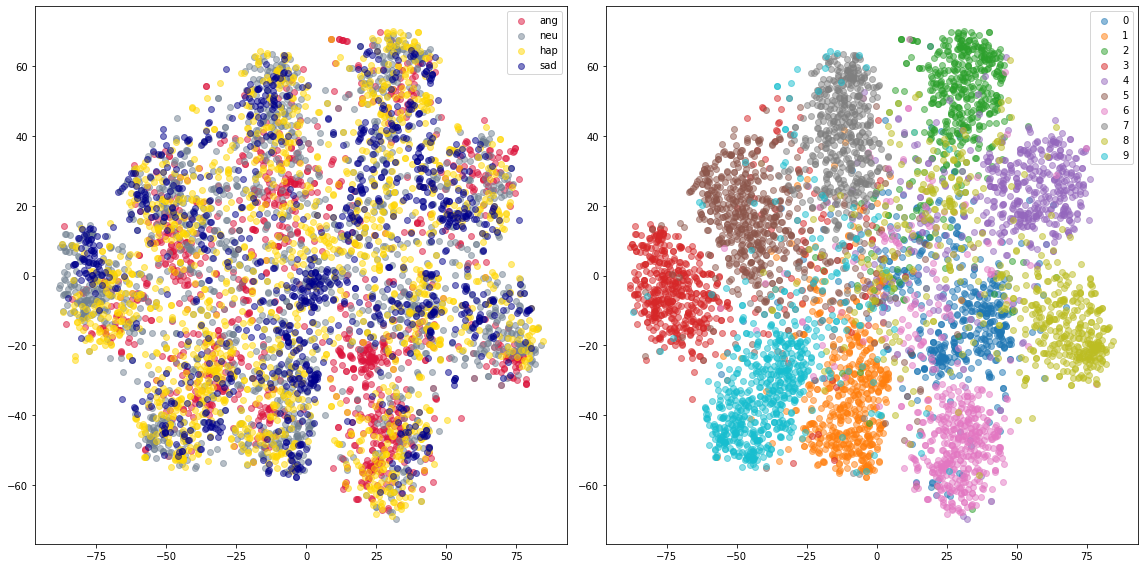

In [13]:
emo_list = ['ang', 'neu', 'hap', 'sad']
color_list = make_color_list(emo_list)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
i = 0
for k in emo_list:
    mask = np.where(iemo_emo_list==k, True, False)

    x = y_tsne[mask][:, 0]
    y = y_tsne[mask][:, 1]
    ax[0].scatter(x, y, label=emo_list[i], color=color_list[i], alpha=0.5)
    i+=1

ax[0].legend()

i = 0
cmap1 = plt.cm.get_cmap('tab10', 10)
mask2 = np.array([True if k in emo_list else False for k in iemo_emo_list])
for k in list(set(iemo_id_list)):
    mask1 = np.where(iemo_id_list==k, True, False)

    mask = mask1 & mask2

    x = y_tsne[mask][:, 0]
    y = y_tsne[mask][:, 1]
    ax[1].scatter(x, y, label=k, color=cmap1(i), alpha=0.5)
    i+=1
    
ax[1].legend()

plt.tight_layout()
plt.show()

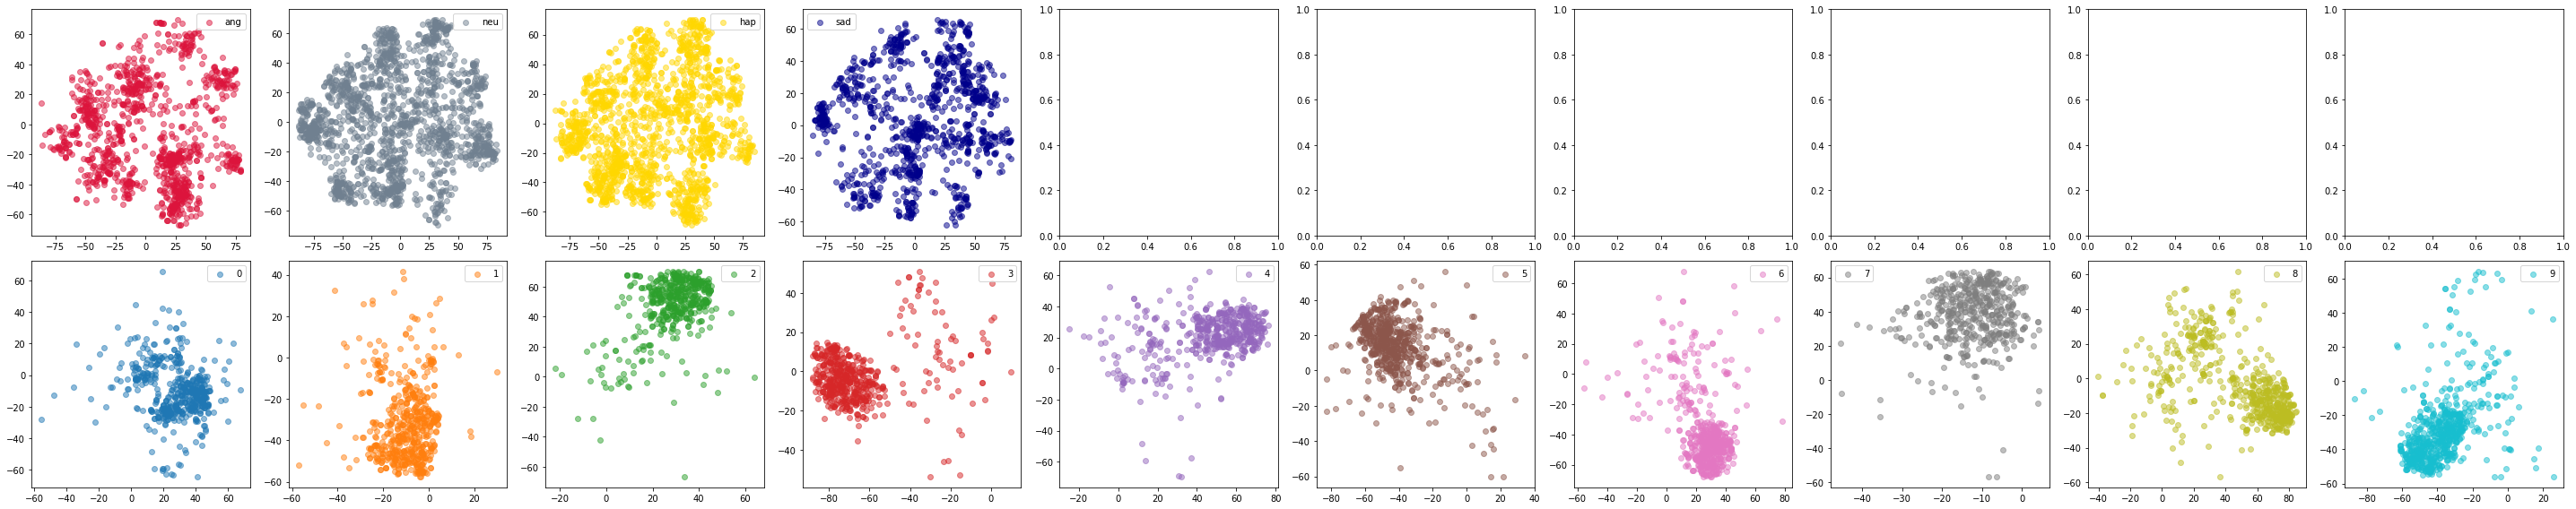

In [16]:
fig, ax = plt.subplots(2, 10, figsize=(40,8))
i = 0
for k in emo_list:
    mask = np.where(iemo_emo_list==k, True, False)

    x = y_tsne[mask][:, 0]
    y = y_tsne[mask][:, 1]
    ax[0][i].scatter(x, y, label=emo_list[i], color=color_list[i], alpha=0.5)
    
    ax[0][i].legend()
    i+=1

i = 0
cmap1 = plt.cm.get_cmap('tab10', 10)
mask2 = np.array([True if k in emo_list else False for k in iemo_emo_list])
for k in list(set(iemo_id_list)):
    mask1 = np.where(iemo_id_list==k, True, False)

    mask = mask1 & mask2

    x = y_tsne[mask][:, 0]
    y = y_tsne[mask][:, 1]
    ax[1][i].scatter(x, y, label=k, color=cmap1(i), alpha=0.5)    
    ax[1][i].legend()
    i +=1
    
plt.tight_layout()
plt.show()

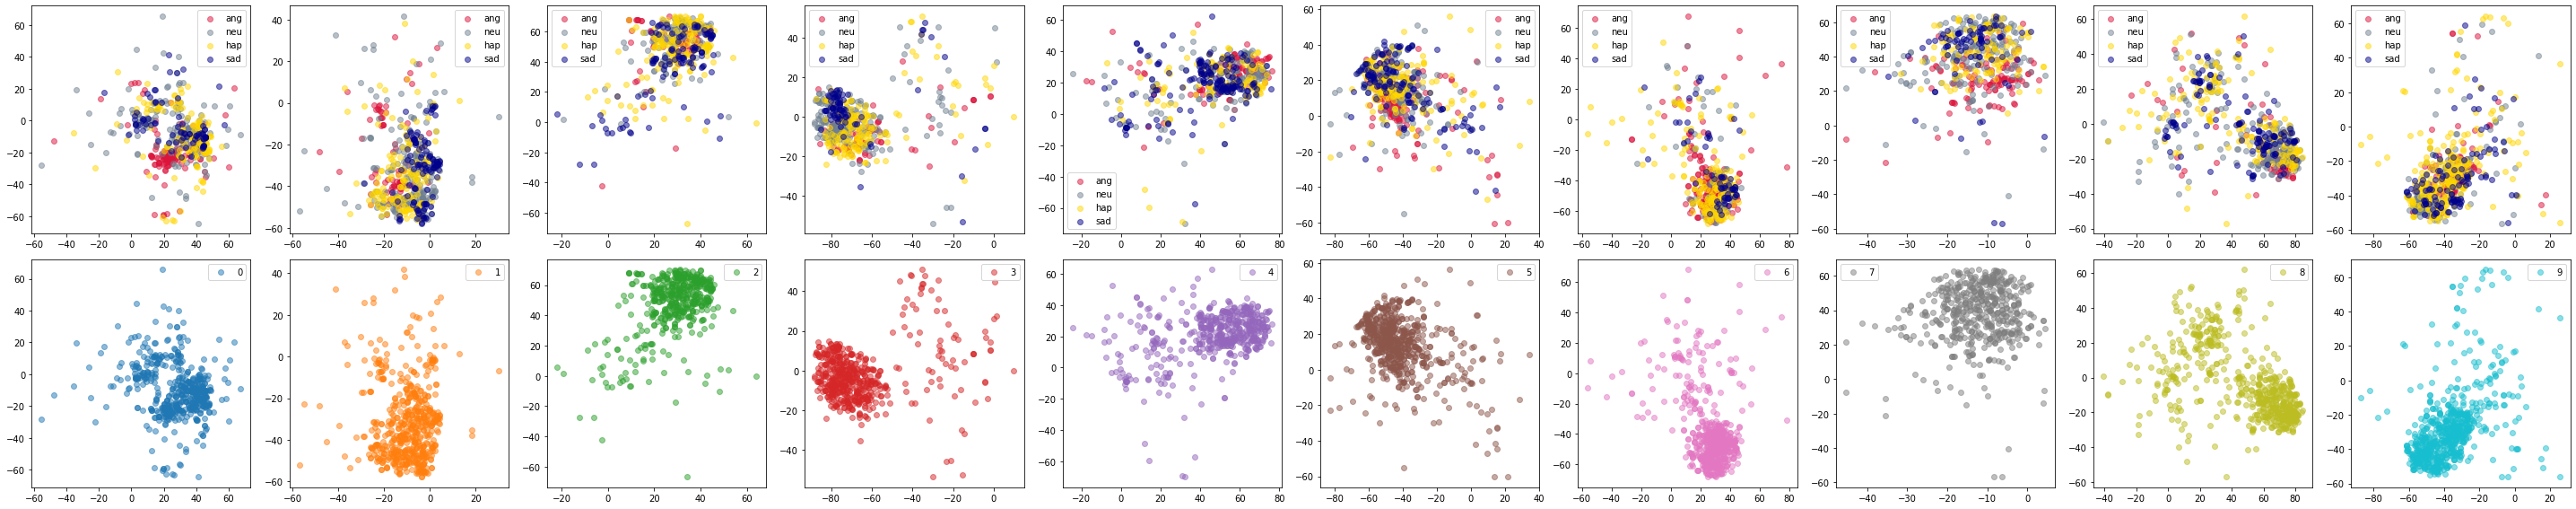

In [24]:
fig, ax = plt.subplots(2, 10, figsize=(40,8))

cmap1 = plt.cm.get_cmap('tab10', 10)

i = 0
e = 0
for pid in list(set(iemo_id_list)):
    mask2 = np.where(iemo_id_list==pid, True, False)
    for k in emo_list:
        mask1 = np.where(iemo_emo_list==k, True, False)

        mask = mask1 & mask2

        x = y_tsne[mask][:, 0]
        y = y_tsne[mask][:, 1]
        ax[0][i].scatter(x, y, label=emo_list[e%4], color=color_list[e%4], alpha=0.5)
        e+=1

    ax[0][i].legend()
    i+=1

i = 0
mask2 = np.array([True if k in emo_list else False for k in iemo_emo_list])
for k in list(set(iemo_id_list)):
    mask1 = np.where(iemo_id_list==k, True, False)

    mask = mask1 & mask2

    x = y_tsne[mask][:, 0]
    y = y_tsne[mask][:, 1]
    ax[1][i].scatter(x, y, label=k, color=cmap1(i), alpha=0.5)    
    ax[1][i].legend()
    i +=1
    
plt.tight_layout()
plt.show()